In [123]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import statsmodels.api as sm

from pandas.tseries.holiday import USFederalHolidayCalendar

In [124]:
data = pd.read_csv('cleaned_data/agg_us_holdings.csv')
data["date_holding"] = pd.to_datetime(data["date_holding"])
data["date_filed"] = pd.to_datetime(data["date_filed"])

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [3]:
data.head()

,cik,date_holding,date_filed,ticker,num_shares,buy_price,sell_price,value,quarter_return
0,886982,1999-12-31,2000-02-14,SRT,35000,28.738155,58.318626,1.005835e+06,1.029310
1,854157,1999-12-31,2000-01-28,RCMT,246000,6.028079,4.368174,1.482907e+06,-0.275362
2,854157,1999-12-31,2000-01-28,RF,20000,10.161595,9.356715,2.032319e+05,-0.079208
3,854157,1999-12-31,2000-01-28,RHI,170000,10.382663,17.238173,1.765053e+06,0.660284
4,854157,1999-12-31,2000-01-28,ROK,327400,11.021953,9.682253,3.608587e+06,-0.121548


In [4]:
close_data = pd.read_csv('raw_data/close_data.csv', index_col=0)
close_data.index = pd.to_datetime(close_data.index)

In [118]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2000-01-01', end='2022-12-31').to_pydatetime()

# If deadline falls on Sat, Sun or Holiday, move to next business day
def get_filing_deadline(quarter_end):
    curr_deadline = quarter_end + datetime.timedelta(days=45)
    while curr_deadline.weekday() >= 5 or curr_deadline in holidays:
        curr_deadline = curr_deadline + datetime.timedelta(days=1)
    return curr_deadline

def get_features(quarter_holdings, fund_filter, var="cik"):
    quarter_end = quarter_holdings["date_holding"].iloc[0]
    
    quarter_holdings = quarter_holdings.copy()
    if quarter_end not in fund_filter:
        return None
    quarter_holdings = quarter_holdings[quarter_holdings[var].isin(fund_filter[quarter_end])]
    quarter_holdings["fund_weight"] = quarter_holdings.groupby(var, group_keys=False).value.apply(lambda x: x / x.sum())
    
    # Percentage of fund holding stock
    perc_holding = quarter_holdings.ticker.value_counts() / quarter_holdings[var].nunique()
    
    # Statistics of portfolio weights of funds holding stock
    mean_weight = quarter_holdings.groupby('ticker').fund_weight.mean()
    median_weight = quarter_holdings.groupby('ticker').fund_weight.median()
    perc_25_weight = quarter_holdings.groupby('ticker').fund_weight.quantile(0.25)
    perc_75_weight = quarter_holdings.groupby('ticker').fund_weight.quantile(0.75)
    
    output = pd.concat([perc_holding, mean_weight, median_weight, perc_25_weight, perc_75_weight], axis=1)
    output.columns =["perc_holding", "mean_weight", "median_weight", "perc_25_weight", "perc_75_weight"]
    
    # Historical return of stocks (from filing deadline)
    filing_deadline = get_filing_deadline(quarter_end)
    latest_prices = close_data[output.index].loc[:filing_deadline]
    last_21d_ret = latest_prices[-21:].pct_change().apply(lambda x: np.prod(1+x)-1)
    last_42d_ret = latest_prices[-42:].pct_change().apply(lambda x: np.prod(1+x)-1)
    last_63d_ret = latest_prices[-63:].pct_change().apply(lambda x: np.prod(1+x)-1)
    output["last_21d_ret"] = last_21d_ret
    output["last_42d_ret"] = last_42d_ret
    output["last_63d_ret"] = last_63d_ret
    
    # Target variable - Future returns (From current filing deadline + 1 to next filing deadline)
    next_filing_deadline = get_filing_deadline(quarter_end + pd.tseries.offsets.QuarterEnd())
    future_ret = close_data[output.index].loc[filing_deadline + datetime.timedelta(days=1):next_filing_deadline
                                             ].pct_change().apply(lambda x: np.prod(1+x)-1)
    output["future_ret"] = future_ret
    # Rebalance at filing deadline + 1 opening
    output["rebalance_date"] = filing_deadline + datetime.timedelta(days=1)
    
    return output

# Generated from fund feature - Filter 1

- Remove size > 80th percentile
- Remove return < 20th percentile
- Remove vol > 80th percentile
- Remove inflow > 80th percentile

In [125]:
fund_features = pd.read_csv('cleaned_data/fund_features.csv')
fund_features["date_holding"] = pd.to_datetime(fund_features["date_holding"])

In [126]:
fund_features["size_rank"] = fund_features.groupby("date_holding")["size"].rank(pct=True)
fund_features["return_rank"] = fund_features.groupby("date_holding")["cum_annual_return"].rank(pct=True)
fund_features["vol_rank"] = fund_features.groupby("date_holding")["annual_volatility"].rank(pct=True)
fund_features["inflow_rank"] = fund_features.groupby("date_holding")["avg_turnover_ratio"].rank(pct=True)

In [127]:
size_filter = fund_features["size_rank"] <= 0.8
return_filter = fund_features["return_rank"] >= 0.2
vol_filter = fund_features["vol_rank"] <= 0.8
inflow_filter = fund_features["inflow_rank"] <= 0.8

filtered_funds = fund_features[size_filter & return_filter & vol_filter & inflow_filter]
fund_filter = filtered_funds.groupby('date_holding').cik.apply(list).to_dict()

In [106]:
comp_count

,remaining_fund_count,filtered_fund_count
date_holding,,
2001-06-30,32,27
2001-09-30,31,27
2001-12-31,81,90
2002-03-31,140,128
2002-06-30,163,162
...,...,...
2021-03-31,2170,2408
2021-06-30,2215,2418
2021-09-30,2241,2408


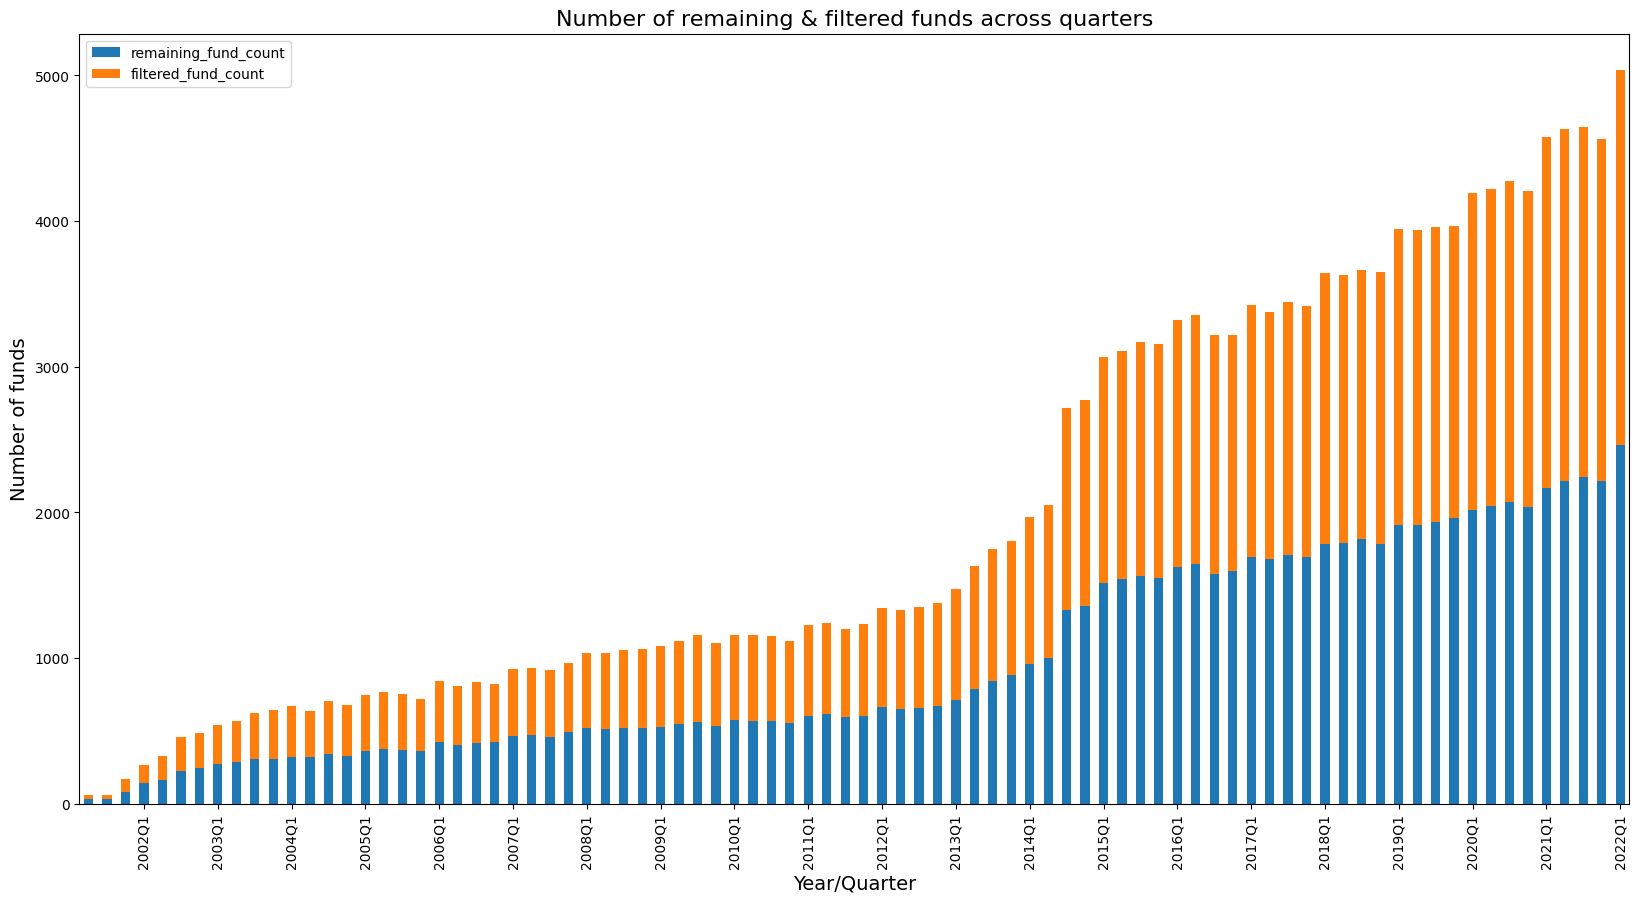

In [102]:
# Start from 2006 (at least 300 observations)
comp_count = pd.DataFrame(filtered_funds.value_counts('date_holding').sort_index())
comp_count["total_fund_count"] = fund_features.value_counts('date_holding').sort_index()
comp_count.rename(columns={0:"remaining_fund_count"},inplace=True)
comp_count["filtered_fund_count"] = comp_count["total_fund_count"] - comp_count["remaining_fund_count"] 
comp_count.drop(columns="total_fund_count", inplace=True)
comp_count.plot(kind='bar',stacked=True,figsize=(20,10))
plt.title("Number of remaining & filtered funds across quarters", fontsize=16)
plt.ylabel("Number of funds",fontsize=14)
plt.xlabel("Year/Quarter",fontsize=14)
plt.xticks(np.arange(3,84,4), [f"{2001+y}Q{q}" for y in np.arange(22) for q in range(1,5)][4:-3:4])
plt.show()

In [10]:
feature_set1 = data.groupby('date_holding').apply(lambda x: get_features(x, fund_filter))

# Filter away non-stock universe features
sp500_tickers = pd.read_csv('raw_data/sp500_meta.csv').ticker
feature_set1 = feature_set1[feature_set1.index.get_level_values(1).isin(sp500_tickers)]
# Change index from date holdings to rebalance date
feature_set1 = feature_set1.reset_index().rename(columns={"level_1":"ticker"}).set_index(['rebalance_date','ticker']).drop(columns="date_holding")

In [11]:
feature_set1

perc_holding   mean_weight  median_weight  \
rebalance_date ticker                                              
2001-08-15     GE          0.875000  2.741326e-01   2.404646e-01   
               PFE         0.843750  1.143254e-02   9.863303e-03   
               MSFT        0.812500  8.682469e-03   6.144190e-03   
               INTC        0.812500  9.413244e-03   9.634298e-03   
               JNJ         0.781250  1.571194e-02   1.386004e-02   
...                             ...           ...            ...   
2022-05-17     NE          0.000813  2.184774e-02   2.184774e-02   
               GP          0.000813  4.070748e-04   4.070748e-04   
               LIFE        0.000813  1.802985e-02   1.802985e-02   
               COMS        0.000813  2.044493e-04   2.044493e-04   
               EQ          0.000407  1.352389e-07   1.352389e-07   

                       perc_25_weight  perc_75_weight  last_21d_ret  \
rebalance_date ticker                                                 
2001-08-15     GE        1.834162e-01    3.699183e-01     -0.092388   
               PFE       7.516347e-03    1.248704e-02      0.064541   
               MSFT      3.021479e-03    9.055933e-03     -0.099276   
               INTC      4.311094e-03    1.215325e-02      0.015683   
               JNJ       1.007158e-02    2.042449e-02      0.037880   
...                               ...             ...           ...   
2022-05-17     NE        2.081939e-02    2.287609e-02      0.033479   
               GP        2.074409e-04    6.067087e-04     -0.456311   
               LIFE      9.020590e-03    2.703910e-02     -0.324561   
               COMS      1.970138e-04    2.118847e-04     -0.585253   
               EQ        1.352389e-07    1.352389e-07     -0.270358   

                       last_42d_ret  last_63d_ret  future_ret  
rebalance_date ticker                                          
2001-08-15     GE         -0.142150     -0.198015   -0.020835  
               PFE        -0.036594     -0.079561    0.031055  
               MSFT       -0.048956     -0.064633    0.043512  
               INTC        0.097143      0.070836    0.052513  
               JNJ         0.095119      0.146527    0.057328  
...                             ...           ...         ...  
2022-05-17     NE          0.114600      0.371186   -0.095906  
               GP         -0.328767     -0.390358   -0.119701  
               LIFE       -0.399610     -0.414449    0.137500  
               COMS       -0.586524     -0.515260   -0.422535  
               EQ         -0.321212     -0.440000    0.165323  

[46049 rows x 9 columns]

In [12]:
feature_set1.to_csv('cleaned_data/feature_set1.csv')

# Generated from subfund feature

In [107]:
subfund_features = pd.read_csv('cleaned_data/subfund_features.csv')
subfund_features["date_holding"] = pd.to_datetime(subfund_features["date_holding"])

In [108]:
subfund_features["size_rank"] = subfund_features.groupby("date_holding")["size"].rank(pct=True)
subfund_features["return_rank"] = subfund_features.groupby("date_holding")["cum_annual_return"].rank(pct=True)
subfund_features["vol_rank"] = subfund_features.groupby("date_holding")["annual_volatility"].rank(pct=True)
subfund_features["inflow_rank"] = subfund_features.groupby("date_holding")["avg_turnover_ratio"].rank(pct=True)

In [111]:
size_filter = subfund_features["size_rank"] <= 0.8
return_filter = subfund_features["return_rank"] >= 0.2
vol_filter = subfund_features["vol_rank"] <= 0.8
inflow_filter = subfund_features["inflow_rank"] <= 0.8

filtered_subfunds = subfund_features[size_filter & return_filter & vol_filter & inflow_filter]
subfund_filter = filtered_subfunds.groupby('date_holding').cik_sector.apply(list).to_dict()

In [114]:
ticker_meta = pd.read_csv('raw_data/ticker_meta.csv')
sector_data = data.merge(ticker_meta[["ticker", "sector"]].drop_duplicates(), on="ticker")
sector_data = sector_data.dropna(subset=["sector"])
sector_data["cik_sector"] = sector_data["cik"].apply(str) + "-" + sector_data["sector"]
sector_data = sector_data.drop(columns=["cik","sector"]).set_index("cik_sector").reset_index()

In [119]:
feature_set2 = sector_data.groupby('date_holding').apply(lambda x: get_features(x, subfund_filter, "cik_sector"))

# Filter away non-stock universe features
sp500_tickers = pd.read_csv('raw_data/sp500_meta.csv').ticker
feature_set2 = feature_set2[feature_set2.index.get_level_values(1).isin(sp500_tickers)]
# Change index from date holdings to rebalance date
feature_set2 = feature_set2.reset_index().rename(columns={"level_1":"ticker"}).set_index(['rebalance_date','ticker']).drop(columns="date_holding")

In [120]:
feature_set2

perc_holding  mean_weight  median_weight  \
rebalance_date ticker                                             
2001-08-15     XOM         0.113537     0.377090       0.406151   
               T           0.109170     0.426623       0.277624   
               PEP         0.104803     0.195405       0.136823   
               PG          0.100437     0.102865       0.084891   
               CVX         0.100437     0.139776       0.058760   
...                             ...          ...            ...   
2022-05-17     NE          0.000053     0.000016       0.000016   
               STR         0.000053     0.000051       0.000051   
               GP          0.000053     0.005321       0.005321   
               DYN         0.000053     0.000006       0.000006   
               MON         0.000053     0.060362       0.060362   

                       perc_25_weight  perc_75_weight  last_21d_ret  \
rebalance_date ticker                                                 
2001-08-15     XOM           0.252700        0.474186     -0.029760   
               T             0.179817        0.848779     -0.001361   
               PEP           0.076296        0.269431     -0.013001   
               PG            0.043112        0.123043      0.042416   
               CVX           0.029206        0.138043      0.062061   
...                               ...             ...           ...   
2022-05-17     NE            0.000016        0.000016      0.033479   
               STR           0.000051        0.000051     -0.025367   
               GP            0.005321        0.005321     -0.456311   
               DYN           0.000006        0.000006     -0.363946   
               MON           0.060362        0.060362     -0.003055   

                       last_42d_ret  last_63d_ret  future_ret  
rebalance_date ticker                                          
2001-08-15     XOM        -0.068841     -0.075083   -0.062004  
               T           0.100584     -0.011926   -0.130074  
               PEP         0.052936      0.009618    0.106993  
               PG          0.164475      0.067450    0.089656  
               CVX        -0.046024     -0.031601   -0.054015  
...                             ...           ...         ...  
2022-05-17     NE          0.114600      0.371186   -0.095906  
               STR         0.173634      0.332117   -0.013771  
               GP         -0.328767     -0.390358   -0.119701  
               DYN        -0.382159     -0.245968    0.930757  
               MON         0.003074      0.004103    0.003049  

[45435 rows x 9 columns]

In [121]:
feature_set2.to_csv('cleaned_data/feature_set2.csv')